

# Classificação de imagens e objetos

> Atenção: este notebook deve ser executado com ambiente do tipo GPU para uma melhor performance.

In [ ]:
!rm -rf fiap-ml-visao-computacional/

In [ ]:
!git clone https://github.com/FIAPON/fiap-ml-visao-computacional.git

Cloning into 'fiap-ml-visao-computacional'...
remote: Enumerating objects: 64816, done.
remote: Counting objects: 100% (735/735), done.
remote: Compressing objects: 100% (669/669), done.
remote: Total 64816 (delta 79), reused 702 (delta 52), pack-reused 64081
Receiving objects: 100% (64816/64816), 564.28 MiB | 26.07 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Updating files: 100% (66490/66490), done.


Vamos agora posicionar o diretório do repositório para a aula respectiva. Nesse caso envie o comando de mudança de diretório.

In [ ]:
%cd fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/

/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado


Importação das bibliotecas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import datetime

from os import listdir
from os.path import isfile, join, isdir, sep

from tqdm import tqdm

# Scikit learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Tensorflow
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras import optimizers

import tensorflow as tf

sns.set_style("whitegrid", {'axes.grid' : False})

## 2. Deep learning a classificação de imagens

Para criar um modelo de Deep Learning para reconhecimento de imagens utilizando o conjunto de dados [COIL-100](https://www.kaggle.com/datasets/jessicali9530/coil100) da Columbia Object Image Library.

![](https://github.com/michelpf/fiap-ml-visao-computacional/blob/master/aula-5-machine-learning-aplicado/imagens/coil100.jpg?raw=true)

In [ ]:
!rm -rf dataset-coil-100-adapted/

In [ ]:
!git clone https://github.com/michelpf/dataset-coil-100-adapted

Cloning into 'dataset-coil-100-adapted'...
remote: Enumerating objects: 7315, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 7315 (delta 2), reused 2 (delta 2), pack-reused 7312
Receiving objects: 100% (7315/7315), 124.11 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (5/5), done.


### 2.1 Identificando as classes

Como um gerador de captchas nem sempre explora todo o alfabeto, vamos identificar exatamente quais as letras são utilizadas para listar todas as possíveis classes deste problema.

In [ ]:
pasta_imagens_treino = "dataset-coil-100-adapted/dataset"
lista_arquivos_classes = [f for f in listdir(pasta_imagens_treino) if isdir(join(pasta_imagens_treino, f))]

lista_classes = list(set(lista_arquivos_classes))
print(lista_classes)
print(len(lista_classes))

['fruit-chewing-gum', 'correction-fluid-red', 'coke', 'alien-toy', 'bulb-plug', 'orange-flower-cup', 'cigarette-box-paramont', 'red-pepper', 'frog-toy', 'pain-relief-dristan', 'iced-tea', 'floater', 'red-sport-car', 'small-shovel', 'floss-waxed', 'teapot', 'men-deodorant', 'japanese-cup', 'scotch-tape', 'red-sport-car-toy', 'strawberry', 'tiny-vase', 'yellow-pot', 'hook', 'orange-soda', 'wood-triangle-piece', 'pain-relief-tylenol', 'baby-powder', 'flower-coffee-cup', 'flower-cup', 'canada-dry-soda', 'fishing-boat-toy', 'fire-department-truck-toy', 'truck-sport-car', 'wood-piece-rectangular-toy', 'sport-car-toy', 'white-sport-car', 'chicken-spice', 'beef-bouillon', 'yellow-racing-car-toy', 'piggy-bank', 'boat-toy', 'plate', 'cinnamon', 'rubber-duck', 'yoyo', 'tomato', 'sandwich', 'chewing-gum', 'red-pot', 'red-floater', 'vaseline', 'onion', 'old-flower-cup', 'pain-relief-anacin', 'vase', 'cream-cheese', 'wood-toy', 'truck-toy', 'cheeseburger', 'racing-toy', 'blue-boat-toy', 'soap-cup', 

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "dataset-coil-100-adapted/dataset",
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb',
    target_size=(128, 128),
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "dataset-coil-100-adapted/dataset",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(128, 128),
    subset='validation')

Found 5100 images belonging to 100 classes.
Found 2100 images belonging to 100 classes.


### 2.2 Treinamento

Colecionando imagens para treinamento e realizando pequenos ajustes para posterior uso na biblioteca de deep-learning do Keras.

Ao todo temos as seguintes quantidades de exemplos:

Vamos também simplificar a informação de escala de cinza. Utilizaremos a forma normalizada, dividindo todos os valores por 255. Desta forma um pixel 100% branco seria 1, e outro 100% preto seria 0.

Realizando a divisão de treinamento e validação.

### 2.3 Arquitetura

Partimos de um modelo simples que na maioria das vezes resolve problemas de OCR como esse. Como foi citado, identificações mais complexas utilizamos outras aboragens ou evolução de uma arquitetura inicial como esta.

In [ ]:
# Construindo um modelo sequencial
model = Sequential()

# Este componente, se trata de um filtro ou uma camada convulacional. Ela será responsável por
# colocar uma janela de kernel, navegar pela imagem e extrair a soma dos pixels de cada janela
# o passo para mover a janela, chamado Stride, por padrão é de um pixel
model.add(Conv2D(10, kernel_size=(3, 3), input_shape=(128, 128, 3), activation="relu"))

# A camada de Pooling (ou MaxPooling2D) tem o papel de reduzir a dimensionalidade. Neste caso, a partir
# da etapa anterior, será dividia em grupos de 2 x 2 pixels e será obtida o maior valor deles
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(10, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# O Dropout é um ruído gerado para evitar overfitting
model.add(Dropout(0.2))

# Esta etapa conhecida como "achatamento" é onde abrimos os dados organizados em tabelas (ou matrizes)
# para uma única linha
model.add(Flatten())

# A camada densa (ou Dense) conectará cada elemento da camada anterior e passará para a próxima
# camada com as classes existentes
model.add(Dense(128, activation="relu"))

# A camada final, determinará qual classe escolher. Por tal razão ela possui a ativação Softmax, que retorna
# a probabilidade por classe
model.add(Dense(100, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 10)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 30, 10)        0         
                                                                 
 flatten (Flatten)           (None, 9000)              0

In [ ]:
!pip install visualkeras==0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 18.4 MB/s eta 0:00:00


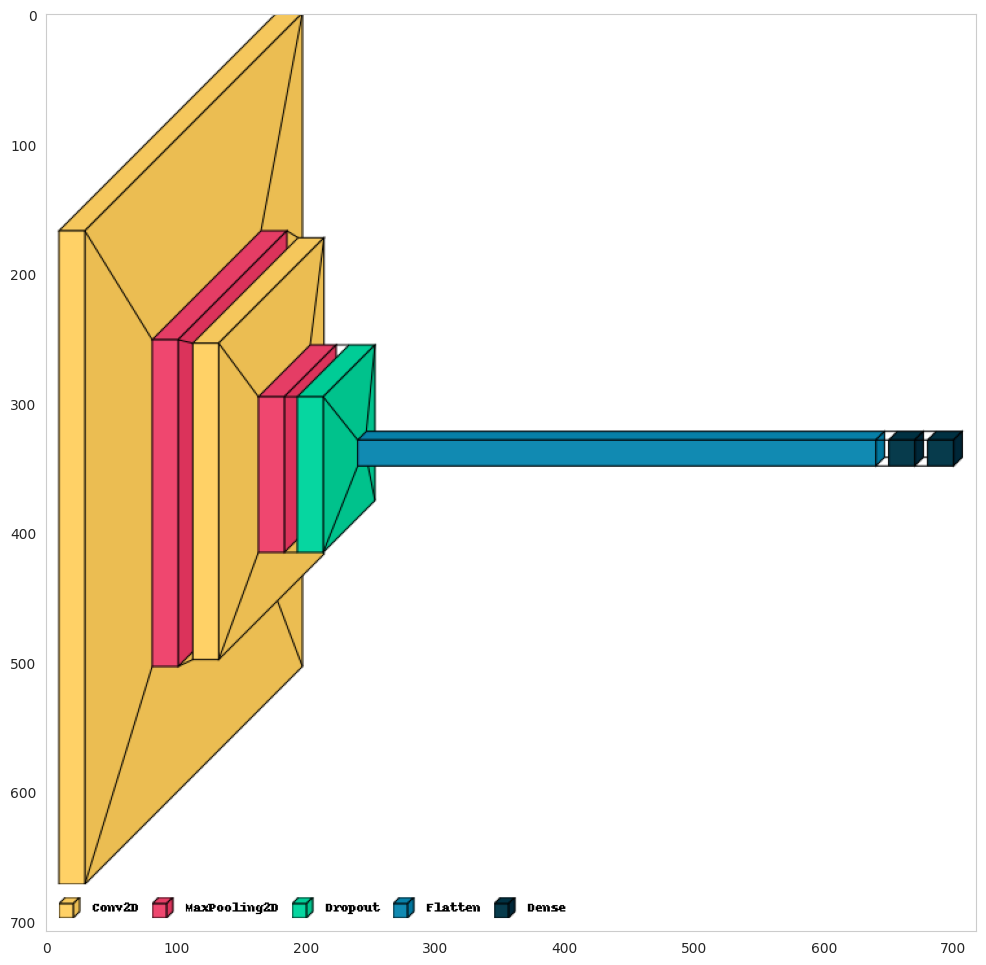

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True, to_file="graph.png")

image = cv2.imread("graph.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,30))
plt.imshow(image)

In [ ]:
!pip install keras-vis==0.4.1

Trecho abaixo ajustado do [Kaggle](https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn/notebook) de Arpit Jain.

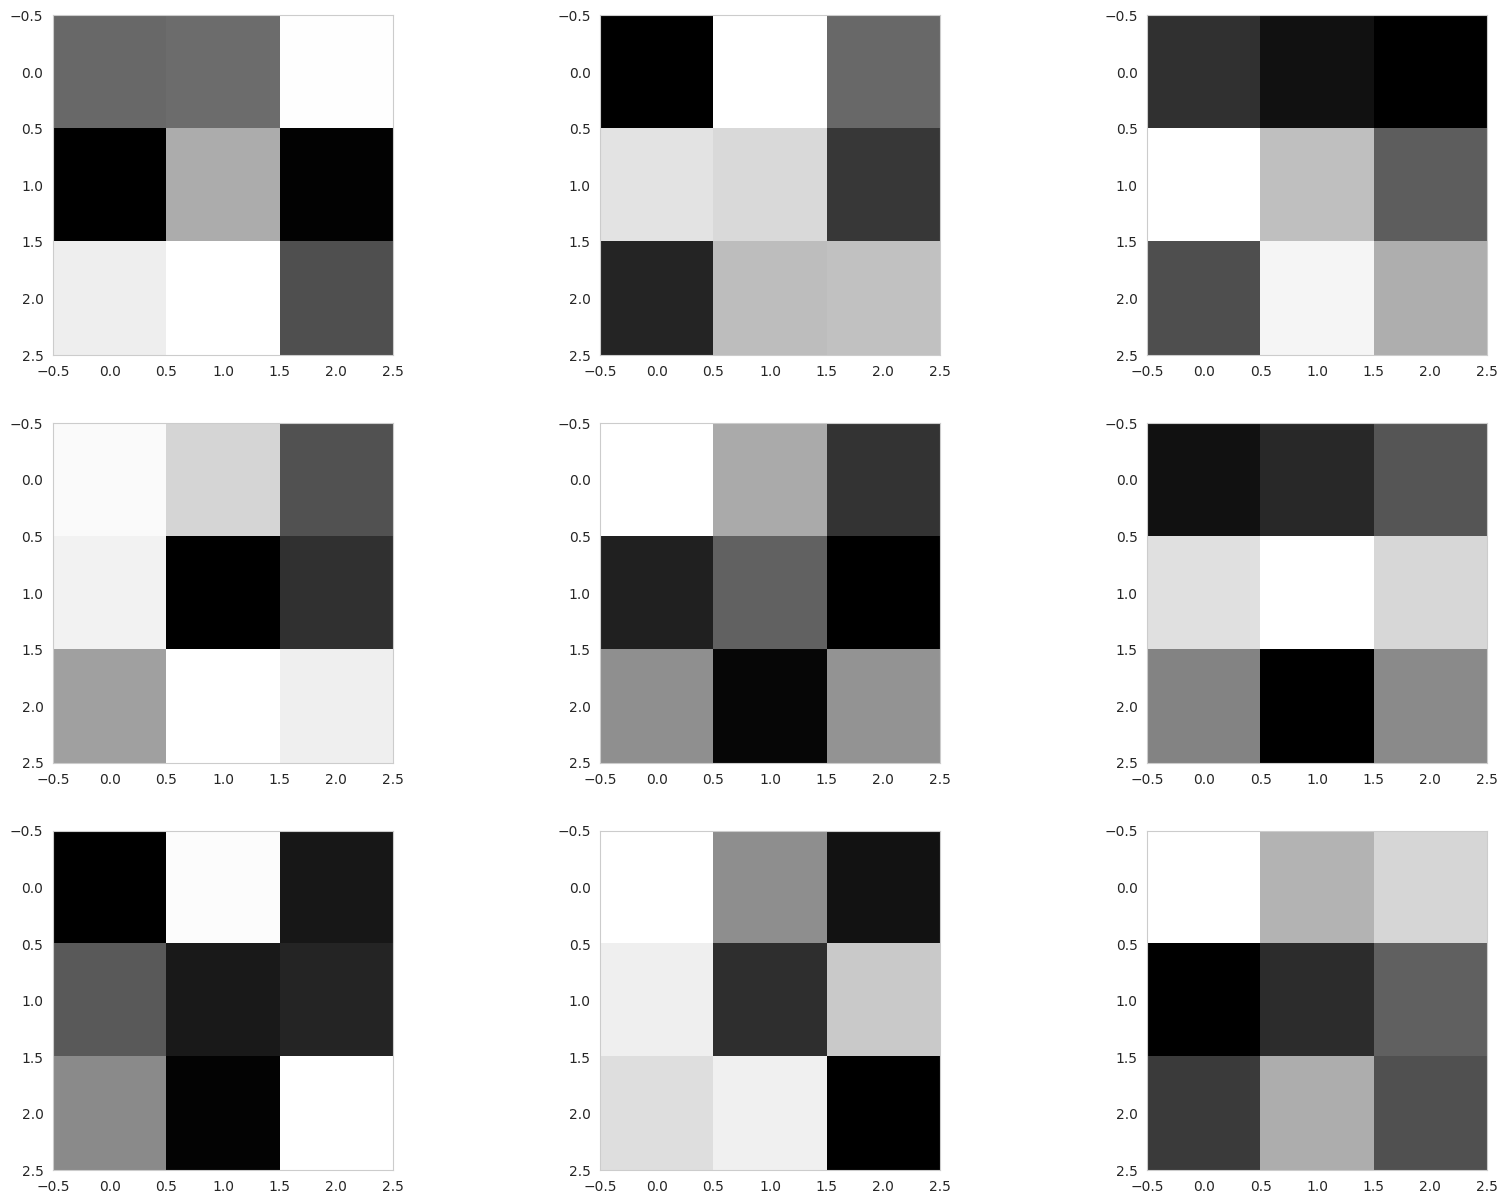

In [ ]:
filters , bias = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 3
ix=1

fig = plt.figure(figsize=(20,15))

for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1


#plot the filters
plt.show()


In [ ]:
model.layers[0]

Para revisão de funções de ativação, em particular [Relu](https://matheusfacure.github.io/2017/07/12/activ-func/).

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=3)

Epoch 1/3
160/160 [==============================] - 30s 159ms/step - loss: 2.9478 - accuracy: 0.5057 - val_loss: 0.8345 - val_accuracy: 0.7895
Epoch 2/3
160/160 [==============================] - 11s 67ms/step - loss: 0.1401 - accuracy: 0.9590 - val_loss: 0.4902 - val_accuracy: 0.8557
Epoch 3/3
160/160 [==============================] - 11s 67ms/step - loss: 0.0385 - accuracy: 0.9902 - val_loss: 0.4653 - val_accuracy: 0.8795


Os gráficos a seguir mostram convergência de acurácia para os dados de treinamento e validação.
Note que o valor do erro, diferentemente da acurácia, não é expressada em porcentagem, portanto erro < 1 é um ótimo valor.

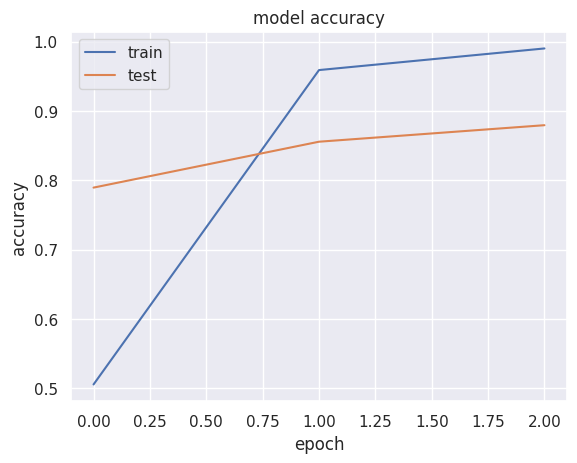

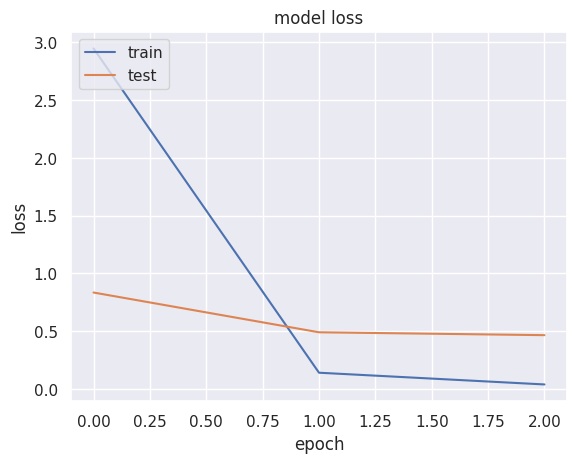

In [ ]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Salvando o modelo para uso posterior. Mesmo imagens pequenas como essas levam vários minutos para treinar.

In [ ]:
!mkdir pesos

In [ ]:
# Salvando o modelo no formato HDf5
model.save("modelos/model.h5")

# Arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights("pesos/weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Uma vez salvo o modelo, nesta etapa é só carregar.

In [ ]:
# carregando o modelo no formato HDf5
model = load_model("modelos/model.h5")
model.load_weights("pesos/weights.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 10)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 30, 10)        0         
                                                                 
 flatten (Flatten)           (None, 9000)              0

### 2.4 Testes de validação
Vamos inferir algumas imagens para verificar visualmente como o classificador está se comportando.
Para isso definimos uma função para normalizar uma imagem do captcha, para extrair os ruídos e posteriomente cada uma das suas letras.

Execução da função. Neste caso não fizemos a inversão da imagem pois as letras foram treinadas com o fundo branco.

In [ ]:
imagens_teste_path = ["dataset-coil-100-adapted/dataset/alien-toy/20.png",
                      "dataset-coil-100-adapted/dataset/telephone/20.png",
                      "dataset-coil-100-adapted/dataset/cheeseburger/20.png"
                      ]

lista_imagem = []

for imagem_path in imagens_teste_path:
    imagem = cv2.imread(imagem_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (128, 128))
    lista_imagem.append(imagem)

lista_imagem_array = np.array(lista_imagem, dtype="float")
lista_imagem_array = preprocess_input(lista_imagem_array)

In [ ]:
pred_probs = model.predict(lista_imagem_array)
y_classes = pred_probs.argmax(axis=-1)

1/1 [==============================] - 0s 183ms/step


In [ ]:
classes_labels = train_generator.class_indices
key_list = list(classes_labels.keys())
val_list = list(classes_labels.values())

In [ ]:
key_list[val_list[y_classes[0]]]

'alien-toy'

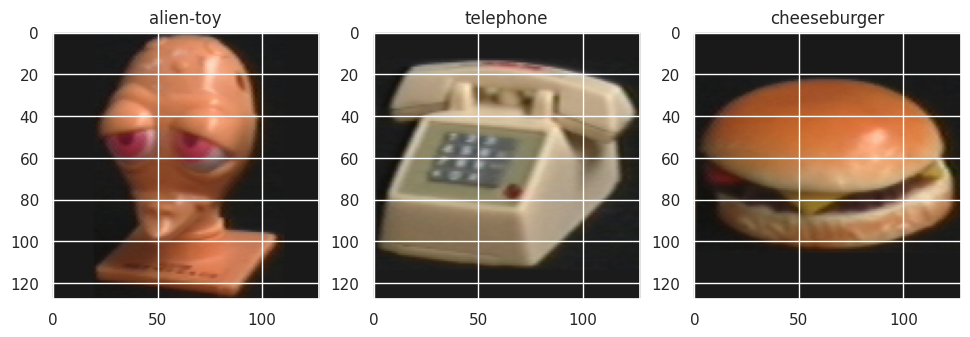

In [ ]:
plt.figure(figsize=(20,10))

for i, imagem in enumerate(lista_imagem):
    plt.subplot(1,5,i+1)
    plt.imshow(imagem)
    plt.title("{}".format(key_list[val_list[y_classes[i]]]))

plt.show()

Agora vamos investigar quais foram as regiões que foram mais atividadas, sendo por sua vez as mais relevantes e com a qual o modelo aprendeu mais. Isso é importante para evitarmos que os nossos modelos aprendam com as características erradas. Um bom exemplo é quando o modelo aprende a classificar uma girafa pelo backgroud árido das savana africanas.

Para a evidenciação destas regiões utilizamos a técnica GradCam, oriundo deste [paper](https://arxiv.org/abs/1610.02391) de Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra.

## 3. Transfer learning para reconhecimento de imagens

Técnica de transfer learning aplicado a deep learnig para classificação de imagens, utilizando classificados com pesos já treinados disponibilizados no Keras.

Foram utilizadas imagens representado dígitos de 0 a 9 com 500 imagens de cada uma, ao todo 5000 imagens.

As imagens de treinamento possuem 400 x 400 de resolução com 3 canais (imagens coloridas representadas em BGR ou RGB).

### 3.1 Geradores de imagens

Conjunto de dados utilizado foi [American Sign Language Digit Dataset](https://www.kaggle.com/rayeed045/american-sign-language-digit-dataset), disponível no Kaggle.

Os geradores utilizados foram aplicados para converter o tamanho adequado do modelo utilizado (224 x 224 pixels) como também para criar novos exemplos a partir das imagens no que chamamos de _data augmentation_, por meio de perturbações da imagem baseado em recorte (```shear```), zoom e orientação horizontal (```horizontal_flip```).

Com a técnica de data augmentation ainda é possível crescer o número de imagens de treinamento ao incorporar as distorções citadas.

In [ ]:
!rm -rf dataset-american-sign-language-digit/

In [ ]:
!git clone https://github.com/michelpf/dataset-american-sign-language-digit

Cloning into 'dataset-american-sign-language-digit'...
remote: Enumerating objects: 4619, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4619 (delta 1), reused 9 (delta 1), pack-reused 4610
Receiving objects: 100% (4619/4619), 111.48 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (5001/5001), done.


In [ ]:
imagem = cv2.imread("dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg")
imagem.shape

(400, 400, 3)

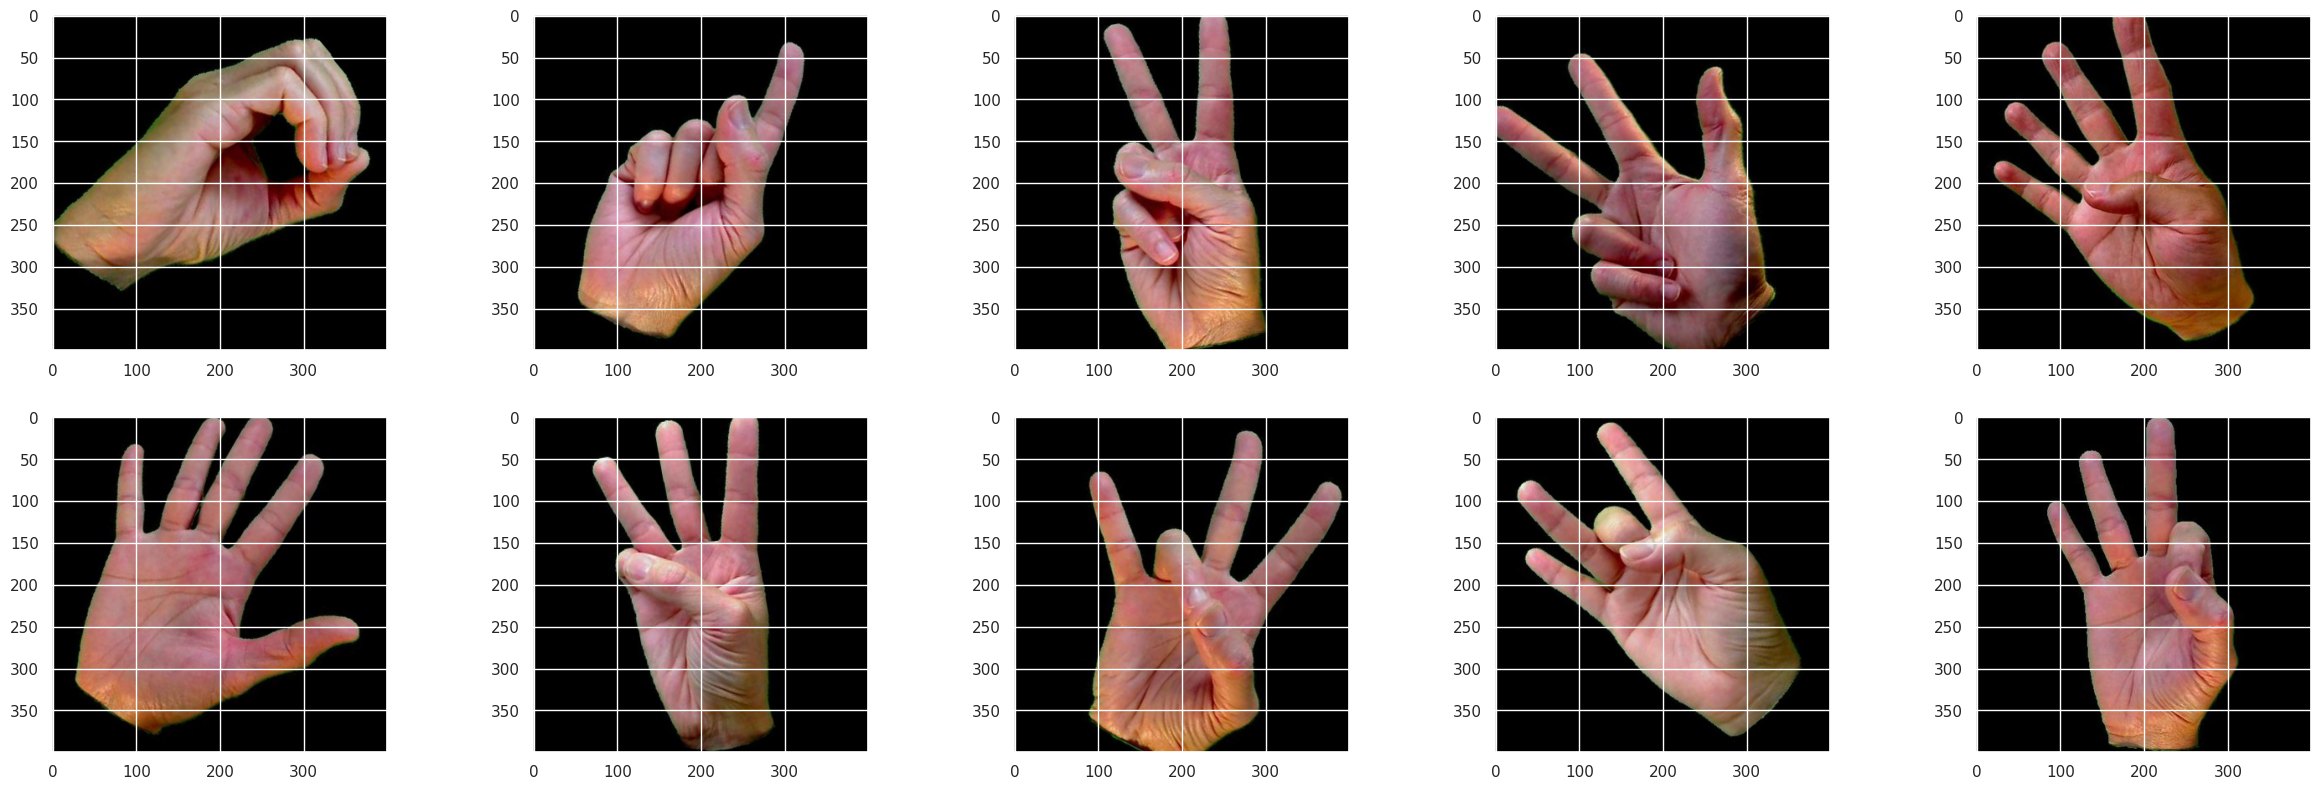

In [ ]:
# Exibição das imagens
img1 = cv2.imread("dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("dataset-american-sign-language-digit/dataset/1/Sign 1 (2).jpeg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread("dataset-american-sign-language-digit/dataset/2/Sign 2 (3).jpeg")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.imread("dataset-american-sign-language-digit/dataset/3/Sign 3 (4).jpeg")
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.imread("dataset-american-sign-language-digit/dataset/4/Sign 4 (5).jpeg")
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.imread("dataset-american-sign-language-digit/dataset/5/Sign 5 (6).jpeg")
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img7 = cv2.imread("dataset-american-sign-language-digit/dataset/6/Sign 6 (8).jpeg")
img7 = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)
img8 = cv2.imread("dataset-american-sign-language-digit/dataset/7/Sign 7 (9).jpeg")
img8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)
img9 = cv2.imread("dataset-american-sign-language-digit/dataset/8/Sign 8 (10).jpeg")
img9 = cv2.cvtColor(img9, cv2.COLOR_BGR2RGB)
img10 = cv2.imread("dataset-american-sign-language-digit/dataset/9/Sign 9 (11).jpeg")
img10 = cv2.cvtColor(img10, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))

plt.subplot(4,5,1)
plt.imshow(img1)
plt.subplot(4,5,2)
plt.imshow(img2)
plt.subplot(4,5,3)
plt.imshow(img3)
plt.subplot(4,5,4)
plt.imshow(img4)
plt.subplot(4,5,5)
plt.imshow(img5)
plt.subplot(4,5,6)
plt.imshow(img6)
plt.subplot(4,5,7)
plt.imshow(img7)
plt.subplot(4,5,8)
plt.imshow(img8)
plt.subplot(4,5,9)
plt.imshow(img9)
plt.subplot(4,5,10)
plt.imshow(img10)

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "dataset-american-sign-language-digit/dataset",
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb',
    target_size=(224,224),
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "dataset-american-sign-language-digit/dataset",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(224,224),
    subset='validation')

Found 3500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


Exibindo as classes identificadas.

In [ ]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

### 3.2. Construindo a rede neural baseado em modelo pré-treinado

O Keras já possui classes especializadas para os seguintes modelos de deep-learning treinados com o conjunto de dados [ImageNet](http://www.image-net.org/):
  
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

Mais detalhes, veja na [documentação do Keras](https://keras.io/applications/).

_O Keras se encarrega de baixar o modelo automaticamente, não é preciso baixar separadamente._

Note que o parâmetro ```include_top=False``` configura o modelo para não utilizar a camada densa original, pois será substituída pelas novas classes.

In [ ]:
conv_base = VGG19(include_top=False)

for layer in conv_base.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


Removendo a camada densa para que seja adaptada para lidar com apenas 2 classes.

In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)
model = Model(conv_base.input, predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 3.3 Treinamento do modelo

In [ ]:
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
110/110 [==============================] - 70s 623ms/step - loss: 1.0540 - accuracy: 0.6600 - val_loss: 0.6545 - val_accuracy: 0.7660
Epoch 2/5
110/110 [==============================] - 69s 630ms/step - loss: 0.2816 - accuracy: 0.9214 - val_loss: 0.4740 - val_accuracy: 0.8273
Epoch 3/5
110/110 [==============================] - 69s 624ms/step - loss: 0.1632 - accuracy: 0.9609 - val_loss: 0.3595 - val_accuracy: 0.8773
Epoch 4/5
110/110 [==============================] - 68s 618ms/step - loss: 0.1181 - accuracy: 0.9709 - val_loss: 0.3311 - val_accuracy: 0.8840
Epoch 5/5
110/110 [==============================] - 68s 621ms/step - loss: 0.0811 - accuracy: 0.9811 - val_loss: 0.2920 - val_accuracy: 0.9047


Armazenamento do modelo e carregamento do modelo pré-treinado.

In [ ]:
# salvando o modelo no formato HDf5
model.save('modelos/modelo-sign.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights('modelos/weights-sign.h5')
with open('modelos/architecture-sign.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
# carregando o modelo no formato HDf5
model = load_model('modelos/modelo-sign.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
with open('modelos/architecture-sign.json') as f:
    model = model_from_json(f.read())

model.load_weights('modelos/weights-sign.h5')

### 3.4 Predição nas imagens de teste

In [ ]:
imagens_teste_path = ["dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/1/Sign 1 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/2/Sign 2 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/3/Sign 3 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/4/Sign 4 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/5/Sign 5 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/6/Sign 6 (20).jpeg",
                      "dataset-american-sign-language-digit/dataset/7/Sign 7 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/8/Sign 8 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/9/Sign 9 (1).jpeg"]

lista_imagem = []

for imagem_path in imagens_teste_path:
    imagem = cv2.imread(imagem_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (224, 224))
    lista_imagem.append(imagem)

In [ ]:
lista_imagem_array = np.array(lista_imagem, dtype="float")
lista_imagem_array = preprocess_input(lista_imagem_array)

Normalizando as imagens de teste, como neste caso não usamos o gerador do Keras, precisamos ajustar manualmente.

In [ ]:
pred_probs = model.predict(lista_imagem_array)
probs = pred_probs.max(1)
probs

1/1 [==============================] - 0s 156ms/step


array([0.9974009 , 0.97561055, 0.9905347 , 0.9997756 , 0.99167836,
       0.9683867 , 0.99842036, 0.93980384, 0.9878812 , 0.9263951 ],
      dtype=float32)

In [ ]:
y_classes = pred_probs.argmax(axis=-1)
y_classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<ipython-input-58-f34603061d6c>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i+1)


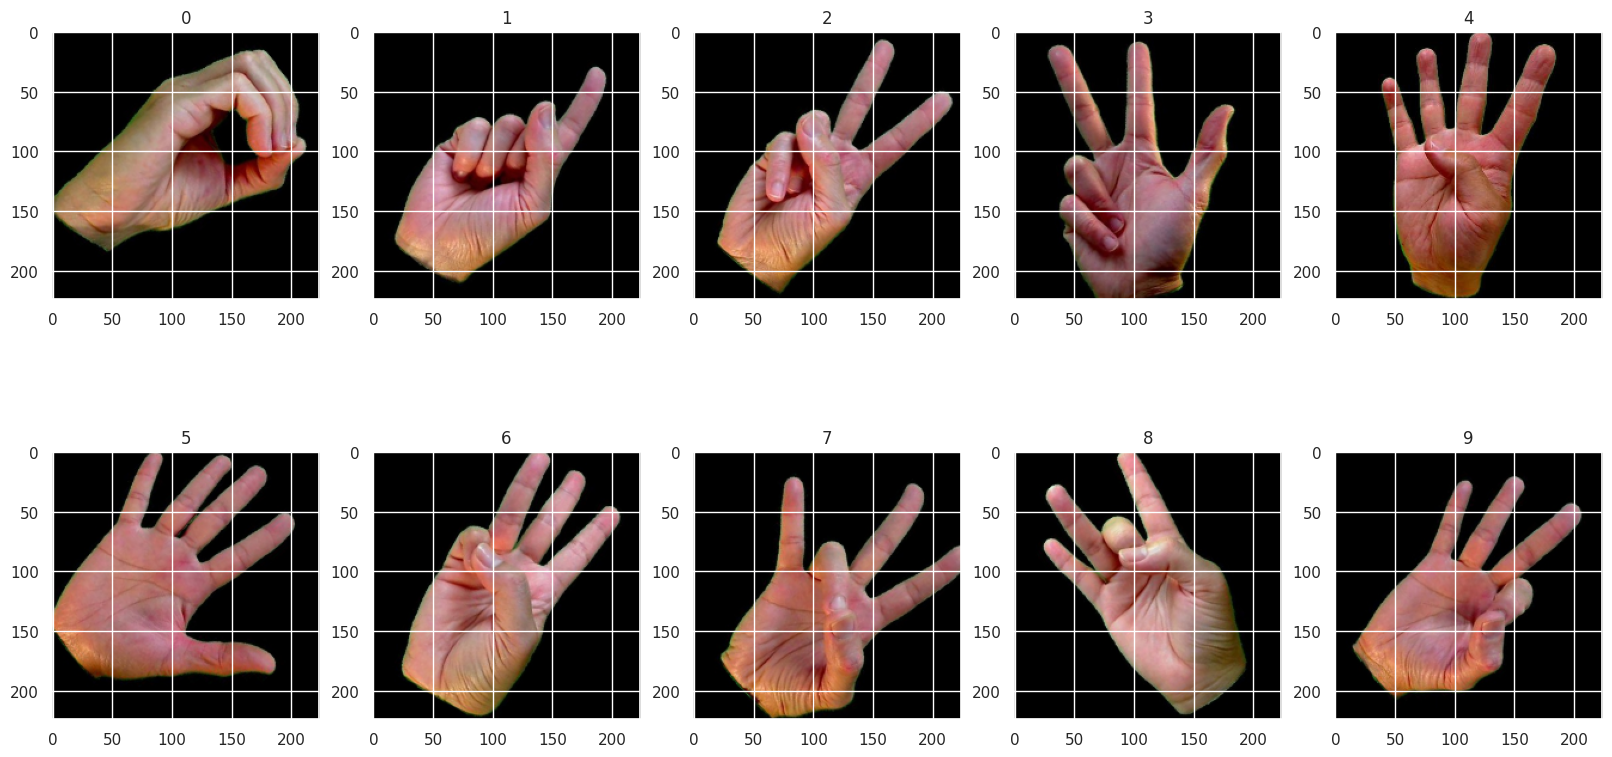

In [ ]:
plt.figure(figsize=(20,10))
plt.axis('off')
plt.grid(False)

for i, imagem in enumerate(lista_imagem):
    plt.subplot(2,5,i+1)
    plt.imshow(imagem)
    plt.title("{}".format(y_classes[i]))

plt.show()

# 4. Estimativa de Profundidade Monocular



In [ ]:
!pip install timm watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.1 MB/s eta 0:00:00


In [ ]:
from IPython.display import HTML
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
import cv2
import torch
import matplotlib.pyplot as plt

In [ ]:
import watermark

%reload_ext watermark
%watermark -a "Version 0" --iversions

Author: Version 0

visualkeras: 0.0.2
tensorflow : 2.15.0
numpy      : 1.25.2
cv2        : 4.8.0
PIL        : 9.4.0
matplotlib : 3.7.1
watermark  : 2.4.3
keras      : 2.15.0
seaborn    : 0.13.1
torch      : 2.1.0+cu121



In [ ]:
VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: { deviceId: 1 } })
  .then(stream => video.srcObject = stream)

var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    var ctx = canvas.getContext('2d');
    ctx.drawImage(video, 0, 0, w, h);
    var imageData = ctx.getImageData(0, 0, w, h);
    var dataUrl = canvas.toDataURL('image/jpeg', %f);

    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(dataUrl);
  }
})
</script>
"""

In [ ]:
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = transforms.small_transform

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Loading weights:  None


/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0], size[1], quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  img = np.asarray(Image.open(f))

  return img

# Capture a photo using the webcam with deviceId 1
img = take_photo()

In [ ]:
imgbatch = transform(img).to(device)

with torch.no_grad():
    imgbatch = imgbatch.to(device)
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

    output = prediction.cpu().numpy()

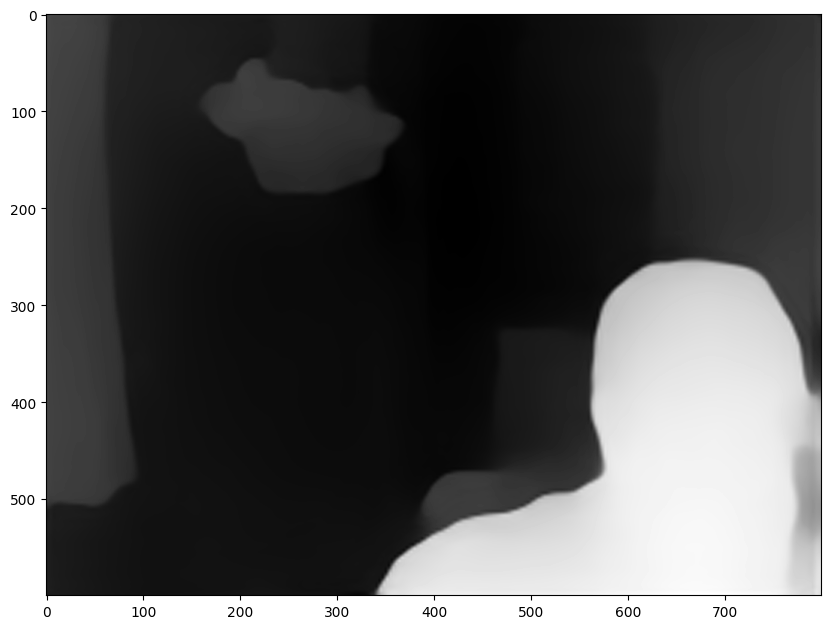

In [ ]:
# Display the captured photo in grayscale
plt.figure(figsize=(10,10))
plt.imshow(output, cmap='gray')
plt.show()

In [ ]:
import requests

def download_image(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()

        with open(save_path, 'wb') as file:
            file.write(response.content)

        print(f"Imagem baixada com sucesso para {save_path}")

    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar a imagem: {e}")

In [ ]:
image_url = "https://howthingswork.org/wp-content/uploads/2017/05/Cars-down-the-road-e1494988061941.jpg"
save_path = "imagem.jpg"

download_image(image_url, save_path)

Imagem baixada com sucesso para imagem.jpg


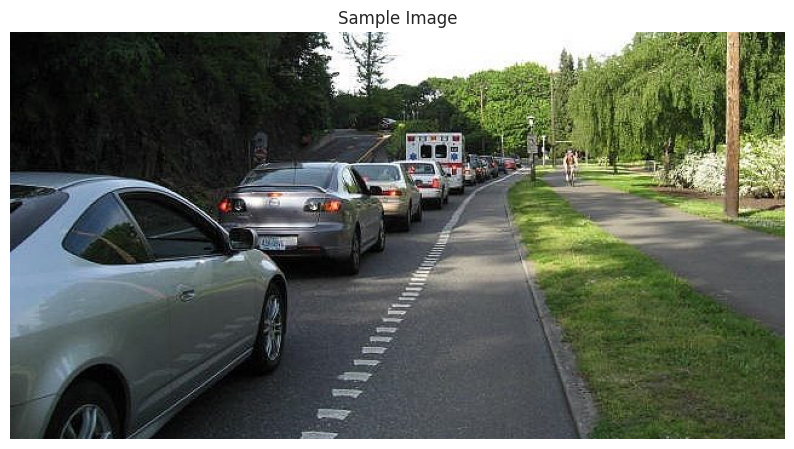

In [ ]:
sample_img = cv2.imread('/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/imagem.jpg')

plt.figure(figsize = [10, 10])

plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [ ]:
imgbatch = transform(sample_img).to(device)

with torch.no_grad():
    imgbatch = imgbatch.to(device)
    prediction = midas(imgbatch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=sample_img.shape[:2],
        mode='bicubic',
        align_corners=False
    ).squeeze()

    output = prediction.cpu().numpy()

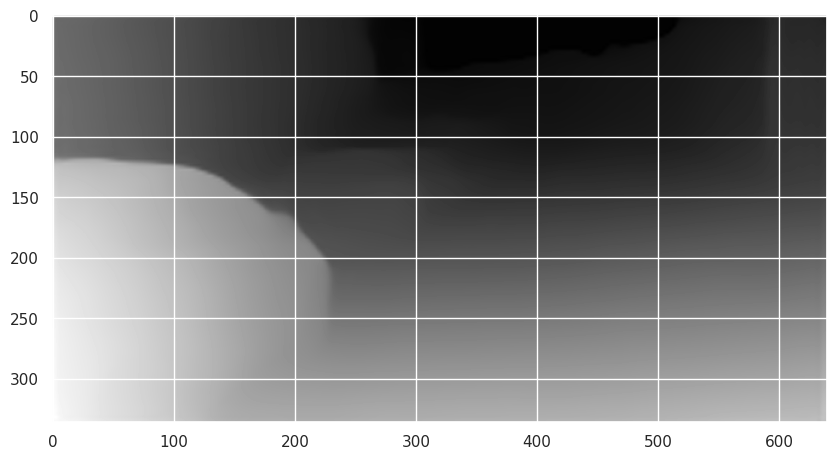

In [ ]:
# Display the captured photo in grayscale
plt.figure(figsize=(10,10))
plt.imshow(output, cmap='gray')
plt.show()

# Detecção de movimento

In [3]:
import cv2
import os

## Subtratores de Fundo:

Subtratores de fundo são algoritmos comumente usados em visão computacional para detectar objetos em movimento em uma cena. Eles funcionam removendo o fundo estático de uma imagem ou sequência de vídeo, deixando apenas os objetos em movimento. Aqui, o código utiliza dois subtratores de fundo diferentes:

**cv2.createBackgroundSubtractorKNN**: Este é um subtrator de fundo baseado em K-nearest neighbors (KNN). Ele funciona criando um modelo de fundo usando os últimos n frames e classificando cada pixel como pertencente ao primeiro plano (objeto em movimento) ou ao fundo. O algoritmo KNN é usado para determinar a probabilidade de um pixel pertencer ao primeiro plano ou ao fundo.

**cv2.createBackgroundSubtractorMOG2**: Este é um subtrator de fundo baseado em Mixture of Gaussians (MOG2). Ele modela cada pixel da imagem como uma mistura de várias distribuições gaussianas. Pixels que têm uma probabilidade baixa de pertencer ao modelo de fundo são considerados parte do primeiro plano. O modelo é atualizado ao longo do tempo para se adaptar a mudanças na cena.

Ambos os subtratores de fundo são usados para criar uma máscara que destaca as áreas em movimento em relação ao fundo estático. Essas máscaras são posteriormente usadas para identificar e rastrear objetos em movimento na cena.

In [4]:
# Criação de um subtrator de fundo KNN
KNN_subtractor = cv2.createBackgroundSubtractorKNN(detectShadows=True)

# Criação de um subtrator de fundo MOG2
MOG2_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=True)

# Escolha do subtrator de fundo a ser utilizado
bg_subtractor = MOG2_subtractor

In [5]:
# Abertura do arquivo de vídeo de entrada
caminho_video_entrada = os.path.join("videos", "pessoas_andando.mp4")
camera = cv2.VideoCapture(caminho_video_entrada)

# Obtenção das propriedades do vídeo de entrada
largura = int(camera.get(cv2.CAP_PROP_FRAME_WIDTH))
altura = int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(camera.get(cv2.CAP_PROP_FPS))

# Criação de VideoWriters para os vídeos de saída
video_mascara_primeiro_plano = cv2.VideoWriter('mascara_primeiro_plano.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (largura, altura))
video_limiar = cv2.VideoWriter('limiar.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (largura, altura))
video_deteccao = cv2.VideoWriter('deteccao.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (largura, altura))

while True:
    ret, quadro = camera.read()
    if not ret:
        break

    # Cálculo da máscara do primeiro plano e atualização do fundo em cada quadro
    mascara_primeiro_plano = bg_subtractor.apply(quadro)

    # Limiarização: se o pixel for maior que 120, pixel igual a 255, caso contrário, pixel igual a 0
    # Criação de uma imagem binária contendo apenas pixels brancos e pretos
    ret, limiar = cv2.threshold(mascara_primeiro_plano.copy(), 120, 255, cv2.THRESH_BINARY)

    # Dilatação expande ou engrossa regiões de interesse em uma imagem
    dilatado = cv2.dilate(limiar, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)

    # Encontrar contornos
    contornos, hierarquia = cv2.findContours(dilatado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Verificar cada contorno e desenhar retângulos delimitadores se excederem um determinado valor
    for contorno in contornos:
        # Se a área do contorno exceder um determinado valor, desenhe retângulos delimitadores
        if cv2.contourArea(contorno) > 50:
            (x, y, w, h) = cv2.boundingRect(contorno)
            cv2.rectangle(quadro, (x, y), (x + w, y + h), (255, 255, 0), 2)

    # Escrever quadros nos vídeos de saída
    video_mascara_primeiro_plano.write(cv2.cvtColor(mascara_primeiro_plano, cv2.COLOR_GRAY2BGR))
    video_limiar.write(cv2.cvtColor(limiar, cv2.COLOR_GRAY2BGR))
    video_deteccao.write(quadro)

# Liberar VideoWriters
video_mascara_primeiro_plano.release()
video_limiar.release()
video_deteccao.release()

# Liberar câmera de entrada
camera.release()

# Fechar todas as janelas do OpenCV
cv2.destroyAllWindows()


## Fluxo Óptico

In [ ]:
import cv2
import numpy as np
import os

# Abertura do arquivo de vídeo de entrada
caminho_video_entrada = os.path.join("videos", "pessoas_andando.mp4")
camera = cv2.VideoCapture(caminho_video_entrada)

# Criação de VideoWriter para o vídeo de saída
video_deteccao = cv2.VideoWriter('deteccao_fluxo_optico.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (largura, altura))

# Configuração do fluxo óptico
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Cor para desenhar os vetores de fluxo óptico
color = (0, 255, 0)

# Captura do primeiro quadro
ret, quadro_anterior = camera.read()
quadro_anterior_cinza = cv2.cvtColor(quadro_anterior, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(quadro_anterior)

while True:
    ret, quadro = camera.read()
    if not ret:
        break

    quadro_cinza = cv2.cvtColor(quadro, cv2.COLOR_BGR2GRAY)

    # Cálculo do fluxo óptico usando o método Lucas-Kanade
    optical_flow = cv2.calcOpticalFlowPyrLK(quadro_anterior_cinza, quadro_cinza, None, None, **lk_params)

    # Seleção dos pontos correspondentes
    good_new = optical_flow[0]
    good_old = optical_flow[1]

    # Desenhar linhas representando o fluxo óptico
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        quadro = cv2.circle(quadro, (a, b), 5, color, -1)

    # Combinar o quadro original com as linhas de fluxo óptico
    output = cv2.add(quadro, mask)

    # Escrever quadro no vídeo de saída
    video_deteccao.write(output)

    # Atualização do quadro anterior e sua versão em escala de cinza
    quadro_anterior_cinza = quadro_cinza.copy()

# Liberar VideoWriter
video_deteccao.release()

# Liberar câmera de entrada
camera.release()

# Fechar todas as janelas do OpenCV
cv2.destroyAllWindows()


## 5. Classificador de Objetos

Para a classificação de objetos iremos utilizar o modelo considerado o mais avançado, preciso e rápido da atualidade, que é a família YOLO (You Only Look Once).

O modelo YOLOv8 é o mais novo estado-da-arte para detecção de objetos, classificação de imagens e tarefas de segmentação de instâncias. O YOLOv8 foi desenvolvido pela Ultralytics, que também criou o influente e definidor de padrões da indústria, modelo YOLOv5. O YOLOv8 inclui várias mudanças arquiteturais e melhorias na experiência de desenvolvedor em relação ao YOLOv5.

### 4.1 Implementação

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import ultralytics

Validando se todas as configurações e GPU foram detectadas com sucesso.

In [ ]:
ultralytics.checks()

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.3/78.2 GB disk)


Método via linha de comando. Nesse caso as predições serão salvas em um diretório pré-determinado conforme a saída do comando.

In [ ]:
!yolo task=detect mode=predict model=yolov8s.pt conf=0.25 source="imagens/dog.jpg" save=True

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/imagens/dog.jpg: 352x640 15 persons, 6 dogs, 2 teddy bears, 359.6ms
Speed: 11.6ms preprocess, 359.6ms inference, 2436.4ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


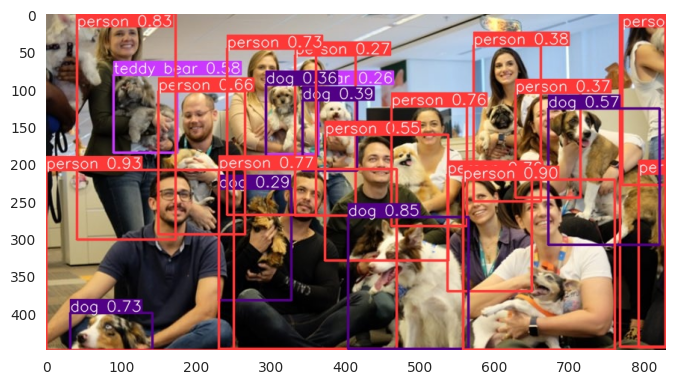

In [ ]:
imagem_result = cv2.imread("runs/detect/predict/dog.jpg", cv2.IMREAD_COLOR)
imagem_result = cv2.cvtColor(imagem_result, cv2.COLOR_BGR2RGB)

plt.imshow(imagem_result)

Uma outra forma de realizar as predições é utilizando a biblioteca diretamente. Neste caso precisamos instanciar a classe YOLO.

In [ ]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 80.6MB/s]


In [ ]:
results = model.predict(source="imagens/dog2.jpeg", conf=0.25)


WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/imagens/dog2.jpeg: 640x384 1 person, 1 car, 1 dog, 218.4ms
Speed: 2.3ms preprocess, 218.4ms inference, 874.5ms postprocess per image at shape (1, 3, 640, 384)


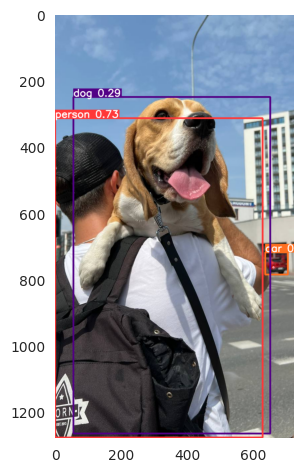

In [ ]:
image_result = results[0].plot()
image_result = cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB)

plt.imshow(image_result)

Mesmo utilizando a classe diretamente no Jupyter, podemos optar por salvar os resultados da mesma maneira como fizemos via execução por linha de comando.

In [ ]:
imagem = cv2.imread("imagens/office.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

results = model.predict(source=imagem, save=True, save_txt=True)


0: 448x640 4 persons, 1 bottle, 3 cups, 1 dining table, 6 laptops, 1 remote, 1 cell phone, 100.8ms
Speed: 3.6ms preprocess, 100.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2
1 label saved to runs/detect/predict2/labels


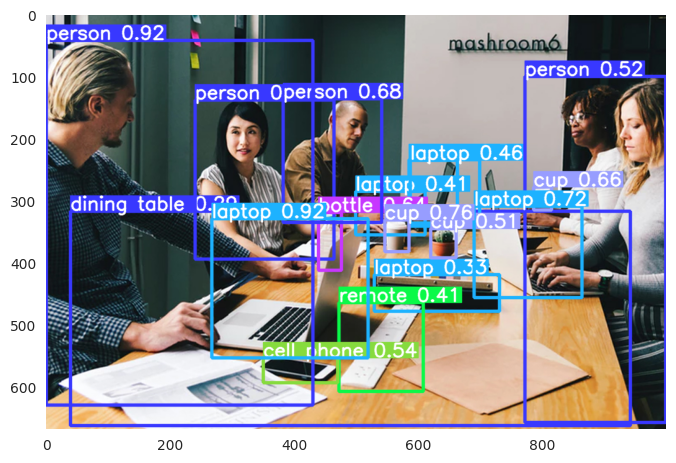

In [ ]:
image_result = results[0].plot()

plt.imshow(image_result)

### 4.2 Treinamento de modelo customizado

Para treinar o modelo YOLOv8 basta usar apenas o comando ```train```. Os parâmetros necessários para essa função são:

* configuração de um arquivo yaml com as informações de caminho das imagens e classes
* épocas
* tamanho da imagem
* nome do seu modelo

Neste exemplo vamos treinar um modelo capaz de detectar buracos em ruas e estradas.

Utilizaremos o dataset [Potholes Detection for YOLOV4](https://www.kaggle.com/datasets/anugrahakbar/potholes-detection-for-yolov4) que foi organizado no repositório abaixo.

Os datasets padrão YOLO são compatíveis com todas as versões, mesmo este dataset originalmente ter sido utilizado para a versão V4.

In [ ]:
!git clone https://github.com/michelpf/dataset-pothole

Cloning into 'dataset-pothole'...
remote: Enumerating objects: 3968, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3968 (delta 1), reused 6 (delta 0), pack-reused 3958
Receiving objects: 100% (3968/3968), 59.84 MiB | 40.05 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
!touch configs_modelo.yaml

In [ ]:
%%writefile configs_modelo.yaml
path: '/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset'
train: 'train/'
val: 'test/'

nc: 1
names: ["pothole"]

Overwriting configs_modelo.yaml


In [ ]:
arquivo_config  = "configs_modelo.yaml"

O treinamento do modelo também realiza em conjunto a validação com os dados separados do treinamento.

Ao final desta etapa é gerado diversas imagens da performance do modelo como curva F1, curva PR, curva P, curva R, matriz de confusão, dentre outras.

In [ ]:
resultados = model.train(data=arquivo_config, epochs=3, imgsz=720, name='yolov8_pothole')

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=configs_modelo.yaml, epochs=3, patience=50, batch=16, imgsz=720, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_pothole5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torc

train: Scanning /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/train.cache... 1562 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1562/1562 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/dataset-pothole/dataset/test.cache... 421 images, 0 backgrounds, 0 corrupt: 100%|██████████| 421/421 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8_pothole5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 736 train, 736 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_pothole5
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      3.66G      2.268      2.725      2.199         41        736: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]

                   all        421        970      0.487      0.429      0.411      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3       3.3G      1.788      2.009       1.75         54        736: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


                   all        421        970      0.438      0.387      0.348      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      3.34G      1.683      1.821      1.671         37        736: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


                   all        421        970      0.603      0.515      0.554      0.281

3 epochs completed in 0.046 hours.
Optimizer stripped from runs/detect/yolov8_pothole5/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8_pothole5/weights/best.pt, 6.3MB

Validating runs/detect/yolov8_pothole5/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]


                   all        421        970      0.597       0.52      0.554      0.281
Speed: 0.5ms preprocess, 3.3ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/detect/yolov8_pothole5


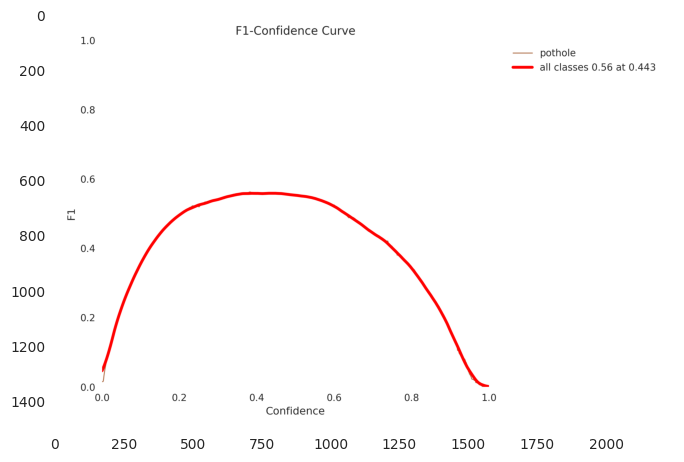

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/F1_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

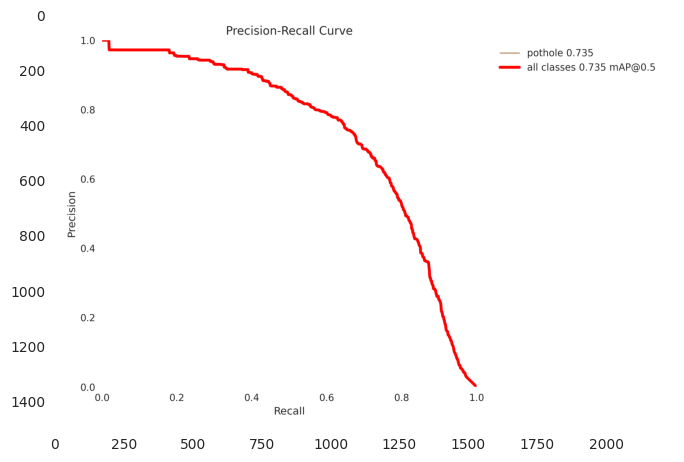

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/PR_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

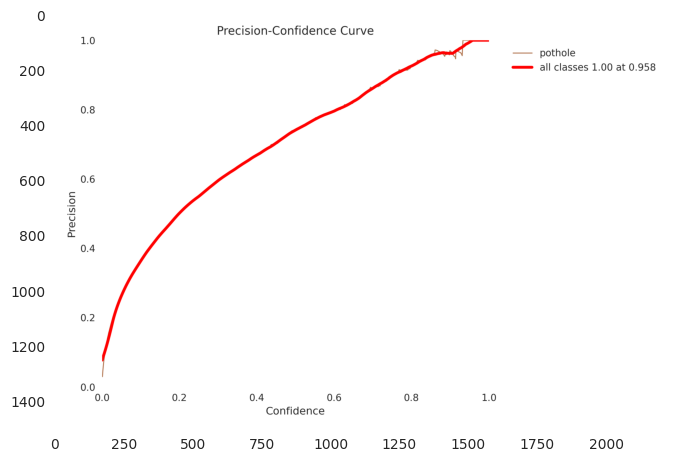

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/P_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

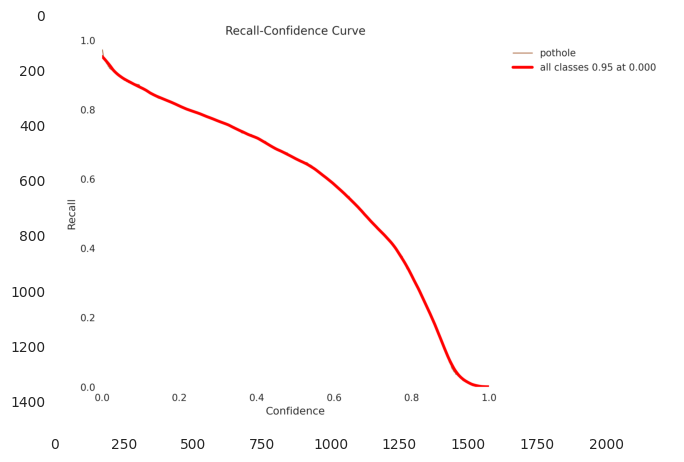

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/R_curve.png", cv2.IMREAD_COLOR)
plt.imshow(image)

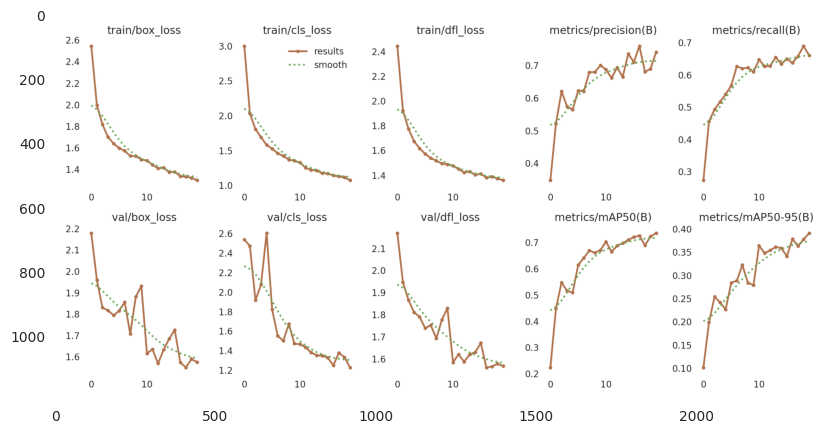

In [ ]:
image = cv2.imread("runs/detect/yolov8_pothole/results.png", cv2.IMREAD_COLOR)
plt.figure(figsize=(10,5))
plt.imshow(image)

Realizando classificações em imagens que não fizeram parte do conjunto de dados.

In [ ]:
dir_resultados = "runs/detect/yolov8_pothole5/weights/best.pt"

In [ ]:
image = cv2.imread("imagens/buraco2.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
model = YOLO(dir_resultados)
results = model.predict(source=image, conf=0.25)


0: 576x736 4 potholes, 111.6ms
Speed: 3.7ms preprocess, 111.6ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 736)


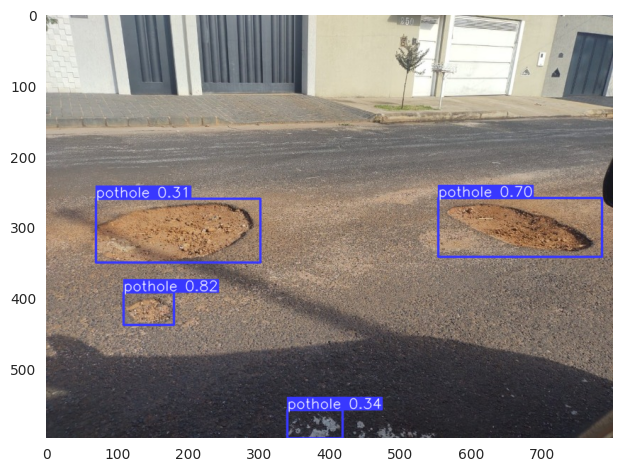

In [ ]:
image_result = results[0].plot()

plt.imshow(image_result)

In [ ]:
image = cv2.imread("imagens/buraco.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
results = model.predict(source=image, conf=0.25)


0: 512x736 1 pothole, 64.0ms
Speed: 3.6ms preprocess, 64.0ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 736)


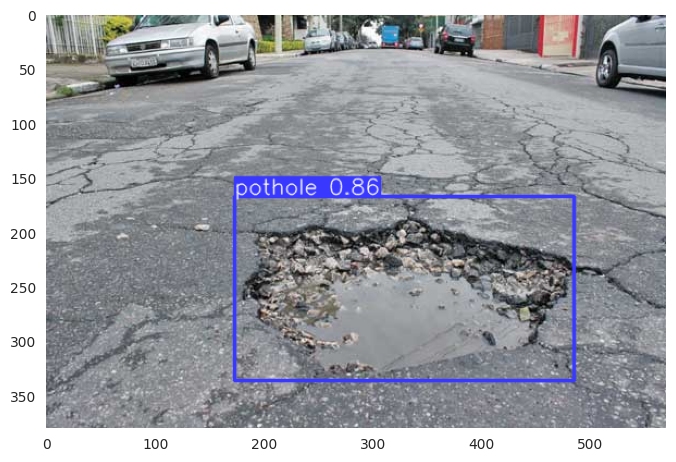

In [ ]:
image_result = results[0].plot()

plt.imshow(image_result)